# Masked Graph Modelling

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
import logging
import os
import os.path as osp
import random
from collections import defaultdict
from dataclasses import dataclass
from functools import partial
from pathlib import Path
from typing import Callable, List, Optional

import datamol as dm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
from lightning.pytorch import LightningModule
from lion_pytorch import Lion
from ogb.utils.features import get_atom_feature_dims, get_bond_feature_dims
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import (
    Compose,
    Lambda,
    Normalize,
    RandomCrop,
    RandomHorizontalFlip,
    RandomResizedCrop,
    ToTensor,
)
from torchvision.transforms.functional import InterpolationMode
from transformers import (
    HfArgumentParser,
    Trainer,
    TrainingArguments,
    ViTImageProcessor,
    ViTMAEConfig,
    ViTMAEForPreTraining,
)

from src.mae.module import MAEDatasetConfig, MAEModule, MAEOptimizerConfig
from src.modules.compound_transforms.masked_transform import (
    ExtractSubstructureContextPair,
    MaskAtom,
    dgl_to_pyg_graph,
    graph_data_obj_to_nx_clf,
)
from src.modules.compound_transforms.pna import PNATransform
from src.modules.transforms import ComplexTransform, SimpleTransform
from src.modules.transforms.color_jitter import ColorJitterPerChannel

In [4]:
for i in range(1, 4):
    if not Path(f"../cpjump{i}/jump/").exists():
        print(f"Mounting cpjump{i}...")
        os.system(f"sshfs bioclust:/projects/cpjump{i}/ ../cpjump{i}")
    else:
        print(f"cpjump{i} already mounted.")

Mounting cpjump1...
Mounting cpjump2...
Mounting cpjump3...


## Dataset

In [5]:
root_dir = "../cpjump1/"
meta_dir = osp.join(root_dir, "jump/metadata")
# jump_dir = osp.join(root_dir, "jump")

print(osp.exists(root_dir), osp.exists(meta_dir))

True True


In [6]:
os.listdir(meta_dir)

['compound.csv.gz',
 'crispr.csv.gz',
 'microscope_config.csv',
 'microscope_filter.csv',
 'orf.csv.gz',
 'plate.csv.gz',
 'README.md',
 'well.csv.gz',
 'compound.csv',
 'crispr.csv',
 'orf.csv',
 'plate.csv',
 'well.csv',
 'complete_metadata.csv',
 'resolution.csv',
 'JUMP-Target-1_compound_metadata.tsv',
 'JUMP-Target-1_compound_platemap.tsv',
 'JUMP-Target-1_crispr_metadata.tsv',
 'JUMP-Target-1_crispr_platemap.tsv',
 'JUMP-Target-1_orf_metadata.tsv',
 'JUMP-Target-1_orf_platemap.tsv',
 'JUMP-Target-2_compound_metadata.tsv',
 'JUMP-Target-2_compound_platemap.tsv',
 'JUMP-MOA_compound_metadata.tsv',
 'local_metadata.csv']

In [7]:
cdf = pd.read_csv(osp.join(meta_dir, "compound.csv.gz"))

In [8]:
cdf

,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI
0,JCP2022_000001,AAAHWCWPZPSPIW-UHFFFAOYSA-N,InChI=1S/C25H31N5O2/c1-4-23-26-14-16-30(23)24-...
1,JCP2022_000002,AAAJHRMBUHXWLD-UHFFFAOYSA-N,InChI=1S/C11H13ClN2O/c12-10-4-2-9(3-5-10)8-14-...
2,JCP2022_000003,AAALVYBICLMAMA-UHFFFAOYSA-N,InChI=1S/C20H15N3O2/c24-19-15-11-17(21-13-7-3-...
3,JCP2022_000004,AAANUZMCJQUYNX-UHFFFAOYSA-N,InChI=1S/C13H22N4O2S/c1-2-7-16-13(5-6-15-16)20...
4,JCP2022_000005,AAAQFGUYHFJNHI-UHFFFAOYSA-N,InChI=1S/C22H22ClN5O2/c1-4-24-20(29)12-18-22-2...
...,...,...,...
116748,JCP2022_116750,ZZZTXDPKNAOZPM-UHFFFAOYSA-N,InChI=1S/C22H27N3O2/c1-14-18(22(27)24-15(2)23-...
116749,JCP2022_116751,ZZZUOLMMTJKOGE-UHFFFAOYSA-N,InChI=1S/C19H17N5O2/c1-23-9-6-13-7-10-24(19(26...
116750,JCP2022_116752,ZZZZIBSVRUABIA-UHFFFAOYSA-N,InChI=1S/C19H13F6N3O2S/c1-11-26-6-5-17(27-11)1...
116751,JCP2022_116753,ZZZZVNLQWWXZTQ-UHFFFAOYSA-N,InChI=1S/C14H20N2O3/c1-18-13-5-3-2-4-12(13)14(...


In [10]:
cpt = PNATransform("inchi")

In [11]:
exs = cdf.head()["Metadata_InChI"].tolist()
exs

['InChI=1S/C25H31N5O2/c1-4-23-26-14-16-30(23)24-9-5-7-21(27-24)22-8-6-15-29(22)25(31)19-10-12-20(13-11-19)32-18-17-28(2)3/h5,7,9-14,16,22H,4,6,8,15,17-18H2,1-3H3',
 'InChI=1S/C11H13ClN2O/c12-10-4-2-9(3-5-10)8-14-7-1-6-13-11(14)15/h2-5H,1,6-8H2,(H,13,15)',
 'InChI=1S/C20H15N3O2/c24-19-15-11-17(21-13-7-3-1-4-8-13)18(12-16(15)20(25)23-19)22-14-9-5-2-6-10-14/h1-12,21-22H,(H,23,24,25)',
 'InChI=1S/C13H22N4O2S/c1-2-7-16-13(5-6-15-16)20(18,19)17-10-11-3-4-12(17)9-14-8-11/h5-6,11-12,14H,2-4,7-10H2,1H3',
 'InChI=1S/C22H22ClN5O2/c1-4-24-20(29)12-18-22-27-26-13(2)28(22)19-10-9-16(30-3)11-17(19)21(25-18)14-5-7-15(23)8-6-14/h5-11,18H,4,12H2,1-3H3,(H,24,29)']

In [12]:
graphs = [cpt(ex) for ex in exs]
graphs

[Graph(num_nodes=32, num_edges=70,
       ndata_schemes={'feat': Scheme(shape=(9,), dtype=torch.int64)}
       edata_schemes={'feat': Scheme(shape=(3,), dtype=torch.int64)}),
 Graph(num_nodes=15, num_edges=32,
       ndata_schemes={'feat': Scheme(shape=(9,), dtype=torch.int64)}
       edata_schemes={'feat': Scheme(shape=(3,), dtype=torch.int64)}),
 Graph(num_nodes=25, num_edges=56,
       ndata_schemes={'feat': Scheme(shape=(9,), dtype=torch.int64)}
       edata_schemes={'feat': Scheme(shape=(3,), dtype=torch.int64)}),
 Graph(num_nodes=20, num_edges=44,
       ndata_schemes={'feat': Scheme(shape=(9,), dtype=torch.int64)}
       edata_schemes={'feat': Scheme(shape=(3,), dtype=torch.int64)}),
 Graph(num_nodes=30, num_edges=66,
       ndata_schemes={'feat': Scheme(shape=(9,), dtype=torch.int64)}
       edata_schemes={'feat': Scheme(shape=(3,), dtype=torch.int64)})]

In [48]:
pyg_graphs = [dgl_to_pyg_graph(graph) for graph in graphs]
pyg_graphs

[Data(edge_index=[2, 70], x=[32, 9], edge_attr=[70, 3]),
 Data(edge_index=[2, 32], x=[15, 9], edge_attr=[32, 3]),
 Data(edge_index=[2, 56], x=[25, 9], edge_attr=[56, 3]),
 Data(edge_index=[2, 44], x=[20, 9], edge_attr=[44, 3]),
 Data(edge_index=[2, 66], x=[30, 9], edge_attr=[66, 3])]

In [22]:
data = pyg_graphs[0]
atom_features = data.n_feat.cpu().numpy()
num_atoms = atom_features.shape[0]
num_atoms

32

In [24]:
get_atom_feature_dims()

[119, 5, 12, 12, 10, 6, 6, 2, 2]

In [53]:
len(pyg_graphs[0].x[0])

9

In [49]:
nx_graphs = [graph_data_obj_to_nx_clf(graph) for graph in pyg_graphs]

In [41]:
%matplotlib inline

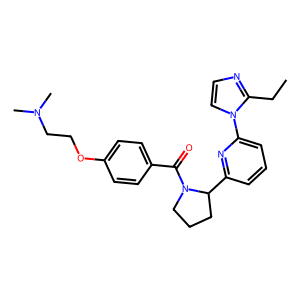

In [47]:
mol = dm.from_inchi(exs[0])

dm.viz.to_image(mol, use_svg=False)
# dm.viz.to_image(mol, n_cols=1)

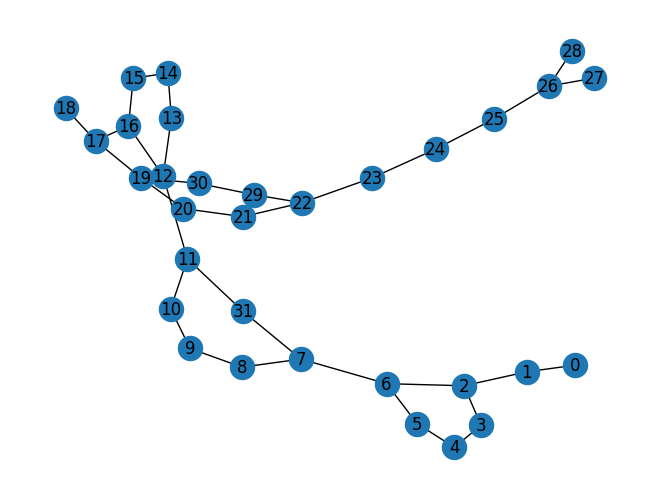

In [50]:
nx.draw(nx_graphs[0], with_labels=True)

In [68]:
get_atom_feature_dims(), get_bond_feature_dims()

([119, 5, 12, 12, 10, 6, 6, 2, 2], [5, 6, 2])

In [81]:
masked_transform = MaskAtom(num_atom_type=119, num_edge_type=5, mask_rate=0.15, mask_edge=True)

In [82]:
masked_graphs = masked_transform(pyg_graphs[0])

In [83]:
masked_graphs

Data(edge_index=[2, 70], x=[32, 9], edge_attr=[70, 3], mask_node_label=[5, 9], masked_atom_indices=[5], masked_x=[32, 9], mask_edge_label=[24, 3], connected_edge_indices=[12])

In [103]:
masked_graphs.masked_x

tensor([[  5,   0,   4,   5,   3,   0,   2,   0,   0],
        [119,   0,   0,   0,   0,   0,   0,   0,   0],
        [  5,   0,   3,   5,   0,   0,   1,   1,   1],
        [  6,   0,   2,   5,   0,   0,   1,   1,   1],
        [  5,   0,   3,   5,   1,   0,   1,   1,   1],
        [  5,   0,   3,   5,   1,   0,   1,   1,   1],
        [  6,   0,   3,   5,   0,   0,   1,   1,   1],
        [  5,   0,   3,   5,   0,   0,   1,   1,   1],
        [119,   0,   0,   0,   0,   0,   0,   0,   0],
        [  5,   0,   3,   5,   1,   0,   1,   1,   1],
        [  5,   0,   3,   5,   1,   0,   1,   1,   1],
        [  5,   0,   3,   5,   0,   0,   1,   1,   1],
        [  5,   0,   4,   5,   1,   0,   2,   0,   1],
        [119,   0,   0,   0,   0,   0,   0,   0,   0],
        [  5,   0,   4,   5,   2,   0,   2,   0,   1],
        [  5,   0,   4,   5,   2,   0,   2,   0,   1],
        [119,   0,   0,   0,   0,   0,   0,   0,   0],
        [  5,   0,   3,   5,   0,   0,   1,   0,   0],
        [ 

In [101]:
graphs[0]

Graph(num_nodes=32, num_edges=70,
      ndata_schemes={'feat': Scheme(shape=(9,), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(3,), dtype=torch.int64)})

In [91]:
context_trans = ExtractSubstructureContextPair(k=3, l1=2, l2=5)

In [96]:
context_graph = context_trans(pyg_graphs[0])

In [97]:
context_graph

Data(edge_index=[2, 70], x=[32, 9], edge_attr=[70, 3], mask_node_label=[5, 9], masked_atom_indices=[5], masked_x=[32, 9], mask_edge_label=[24, 3], connected_edge_indices=[12], x_substruct=[13, 2], edge_attr_substruct=[26, 2], edge_index_substruct=[2, 26], center_substruct_idx=[1], x_context=[11, 2], edge_attr_context=[18, 2], edge_index_context=[2, 18], overlap_context_substruct_idx=[4])

In [ ]:
def compute_accuracy(pred, target):
    return float(torch.sum(torch.max(pred.detach(), dim=1)[1] == target).cpu().item()) / len(pred)


def do_AttrMasking(batch, criterion, node_repr, molecule_atom_masking_model):
    target = batch.mask_node_label[:, 0]
    node_pred = molecule_atom_masking_model(node_repr[batch.masked_atom_indices])
    attributemask_loss = criterion(node_pred.double(), target)
    attributemask_acc = compute_accuracy(node_pred, target)
    return attributemask_loss, attributemask_acc


def cycle_index(num, shift):
    arr = torch.arange(num) + shift
    arr[-shift:] = torch.arange(shift)
    return arr


def do_ContextPred(
    batch,
    criterion,
    molecule_substruct_model,
    molecule_context_model,
    molecule_readout_func,
    contextpred_neg_samples,
    use_image=True,
    molecule_img_repr=None,
    mol_img_projection_head=None,
    normalize=True,
):
    # creating substructure representation
    substruct_repr = molecule_substruct_model(batch.x_substruct, batch.edge_index_substruct, batch.edge_attr_substruct)[
        batch.center_substruct_idx
    ]

    # creating context representations
    overlapped_node_repr = molecule_context_model(batch.x_context, batch.edge_index_context, batch.edge_attr_context)[
        batch.overlap_context_substruct_idx
    ]

    # positive context representation
    # readout -> global_mean_pool by default
    context_repr = molecule_readout_func(overlapped_node_repr, batch.batch_overlapped_context)

    # Use image embedding
    if molecule_img_repr is not None and use_image:
        if normalize:
            context_repr = F.normalize(context_repr, dim=-1)
            molecule_img_repr = F.normalize(molecule_img_repr, dim=-1)

        context_repr = torch.cat([context_repr, molecule_img_repr], dim=1)
        context_repr = mol_img_projection_head(context_repr)  # reproject to the same dim as context_repr

        # context_repr = 0.8 * context_repr + 0.2 * molecule_img_repr

    # negative contexts are obtained by shifting
    # the indices of context embeddings
    neg_context_repr = torch.cat(
        [context_repr[cycle_index(len(context_repr), i + 1)] for i in range(contextpred_neg_samples)], dim=0
    )

    num_neg = contextpred_neg_samples
    pred_pos = torch.sum(substruct_repr * context_repr, dim=1)
    pred_neg = torch.sum(substruct_repr.repeat((num_neg, 1)) * neg_context_repr, dim=1)

    loss_pos = criterion(pred_pos.double(), torch.ones(len(pred_pos)).to(pred_pos.device).double())
    loss_neg = criterion(pred_neg.double(), torch.zeros(len(pred_neg)).to(pred_neg.device).double())

    contextpred_loss = loss_pos + num_neg * loss_neg

    num_pred = len(pred_pos) + len(pred_neg)
    contextpred_acc = (torch.sum(pred_pos > 0).float() + torch.sum(pred_neg < 0).float()) / num_pred
    contextpred_acc = contextpred_acc.detach().cpu().item()

    return contextpred_loss, contextpred_acc